In [1]:
import os
import json
import sys
import pandas as pd
import torch

PROJECT_ROOT = "/media/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")


from src.training.eval import evaluate
from src.models.unet import UNet
from src.pruning.model_inspect import model_to_dataframe_with_l1, get_pruning_masks_blockwise, compute_actual_prune_ratios, compute_l1_norms, compute_l1_stats
from src.pruning.rebuild import rebuild_pruned_unet, find_prev_conv_name

✅ Added project root to sys.path:
   /media/ttoxopeus/basic_UNet


In [2]:
# # Create baseline model
# model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
# df = model_to_dataframe_with_l1(model, remove_nan_layers=True)
# pd.set_option('display.max_rows', None)
# display(df)

# 1️⃣ Create model
model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
state = torch.load("/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/baseline/training/final_model.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()

# Path to your metrics file
metrics_path = "/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/baseline/evaluation/eval_metrics.json"

# Load JSON
with open(metrics_path, "r") as f:
    metrics = json.load(f)

# Extract values
mean_dice = metrics["mean_dice"]
mean_iou = metrics["mean_iou"]
per_class = metrics["per_class"]

# Print formatted output
print("✅ Evaluation on baseline model!")
print(f"📊 Mean Dice: {mean_dice:.4f}")
print(f"📊 Mean IoU:  {mean_iou:.4f}")
print("───────────────────────────────")

for class_name, vals in per_class.items():
    print(f"{class_name:12s}  Dice={vals['dice']:.4f}  IoU={vals['iou']:.4f}")

print("───────────────────────────────")


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=64
Encoder 2 : in=64   → out=128
Encoder 3 : in=128  → out=256
Encoder 4 : in=256  → out=512
Bottleneck : in=512  → out=1024
Decoder 1 : skip=512  + up=1024 → out=512
Decoder 2 : skip=256  + up=512  → out=256
Decoder 3 : skip=128  + up=256  → out=128
Decoder 4 : skip=64   + up=128  → out=64
Output conv: 64 → 4

✅ Evaluation on baseline model!
📊 Mean Dice: 0.7805
📊 Mean IoU:  0.7236
───────────────────────────────
Background    Dice=0.9859  IoU=0.9725
RV            Dice=0.6487  IoU=0.6074
Myocardium    Dice=0.7080  IoU=0.5951
LV            Dice=0.7795  IoU=0.7195
───────────────────────────────


In [3]:
# 2️⃣ Compute per-filter L1 norms
norms = compute_l1_norms(model)

# 3️⃣ Compute L1 statistics from norms
l1_stats = compute_l1_stats(norms)

# 4️⃣ (Optional) define block ratios for later reference
#block_ratios = {"encoders.0": 0.2, "encoders.1": 0.3, "bottleneck": 0.4}

# 5️⃣ Build DataFrame with stats
df = model_to_dataframe_with_l1(
    model,
    l1_stats=l1_stats,
    remove_nan_layers=True
)

# 6️⃣ Display full DataFrame
pd.set_option("display.max_rows", None)
display(df)


,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.495652,0.926844,2.097913,0.256913,None,None
1,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,12.306095,11.647865,12.843674,0.293449,None,None
2,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,12.306599,11.462764,13.033517,0.299653,None,None
3,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,17.793797,17.050240,18.758783,0.287590,None,None
4,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,17.849253,17.208534,18.622089,0.282300,None,None
5,encoders.2.net.3,Conv2d,"(256, 256, 3, 3)",256,256,589824,26.448940,25.499815,27.497488,0.372540,None,None
6,encoders.3.net.0,Conv2d,"(512, 256, 3, 3)",256,512,1179648,26.525261,25.495872,27.505020,0.381423,None,None
7,encoders.3.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,41.290726,39.464928,43.355747,0.709517,None,None
8,bottleneck.net.0,Conv2d,"(1024, 512, 3, 3)",512,1024,4718592,41.850498,38.291759,46.219841,1.172629,None,None
9,bottleneck.net.3,Conv2d,"(1024, 1024, 3, 3)",1024,1024,9437184,69.198265,59.006336,85.401810,4.713773,None,None


In [4]:
block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.0,
    "encoders.1": 0.0,
    "encoders.2": 0.0,
    "encoders.3": 0.0,

    # --- Bottleneck ---
    "bottleneck": 0.2,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.0,
    "decoders.3": 0.0,
    "decoders.5": 0.0,
    "decoders.7": 0.0,
}


# Then get the pruning masks
masks = get_pruning_masks_blockwise(
    model=model,
    norms=norms,
    block_ratios=block_ratios,
    default_ratio=0.25
)

🔧 Generating pruning masks...

Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block bottleneck      | Layer bottleneck.net.0          | ratio=0.20 | thresh=40.7942 | kept 819/1024
Block bottleneck      | Layer bottleneck.net.3          | ratio=0.20 | thresh=64.5374 | kept 819/1024
Block decoders.0      | Layer decoders.0                | ratio=0.25 | thresh=23.8789 | kept 768/1024
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.2      | Layer decoders.2     

🔧 Rebuilding pruned UNet architecture...
Encoder features: [64, 128, 256, 512]
Bottleneck out_channels: 819
Decoder features: [512, 256, 128, 64]
Encoder features: [64, 128, 256, 512]
Bottleneck out_channels: 819
Decoder features: [512, 256, 128, 64]

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=64
Encoder 2 : in=64   → out=128
Encoder 3 : in=128  → out=256
Encoder 4 : in=256  → out=512
Bottleneck : in=512  → out=819
Decoder 1 : skip=512  + up=819  → out=512
Decoder 2 : skip=256  + up=512  → out=256
Decoder 3 : skip=128  + up=256  → out=128
Decoder 4 : skip=64   + up=128  → out=64
Output conv: 64 → 4

✅ Built pruned UNet | enc: [64, 128, 256, 512], dec: [512, 256, 128, 64], bottleneck: 819
✅ Copied weights for encoders.0.net.0 | shape: torch.Size([64, 1, 3, 3])
✅ Copied weights for encoders.0.net.3 | shape: torch.Size([64, 64, 3, 3])
✅ Copied weights for encoders.1.net.0 | shape: torch.Size([128, 64, 3, 3])
✅ Copied weights for encoders.1.net.3 | shape: to

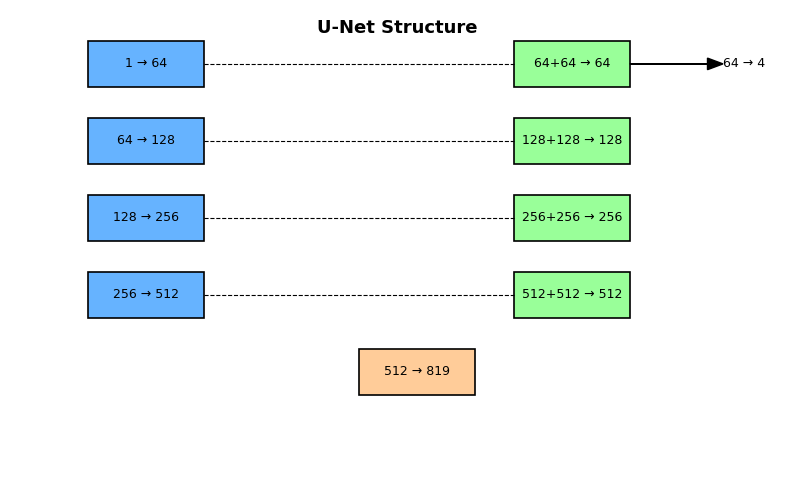

💾 Saved pruned model to /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
🧾 Saved metadata to: /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model_meta.json
✅ UNet successfully rebuilt.


In [5]:
pruned_model = rebuild_pruned_unet(
    model,
    masks, 
    save_path="/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth")

post_ratios = compute_actual_prune_ratios(model, pruned_model)

In [6]:
# df_pruned = model_to_dataframe_with_l1(
#     pruned_model,
#     remove_nan_layers=True,
#     block_ratios=block_ratios,
#     post_prune_ratios=post_ratios
# )
# display(df_pruned)


df_pruned = model_to_dataframe_with_l1(
    pruned_model,
    l1_stats=l1_stats,
    remove_nan_layers=True, 
    block_ratios=block_ratios,
    post_prune_ratios=post_ratios
)

display(df_pruned)

,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.495652,0.926844,2.097913,0.256913,0.0,0.0
1,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,12.306095,11.647865,12.843674,0.293449,0.0,0.0
2,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,12.306599,11.462764,13.033517,0.299653,0.0,0.0
3,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,17.793797,17.050240,18.758783,0.287590,0.0,0.0
4,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,17.849253,17.208534,18.622089,0.282300,0.0,0.0
5,encoders.2.net.3,Conv2d,"(256, 256, 3, 3)",256,256,589824,26.448940,25.499815,27.497488,0.372540,0.0,0.0
6,encoders.3.net.0,Conv2d,"(512, 256, 3, 3)",256,512,1179648,26.525261,25.495872,27.505020,0.381423,0.0,0.0
7,encoders.3.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,41.290726,39.464928,43.355747,0.709517,0.0,0.0
8,bottleneck.net.0,Conv2d,"(819, 512, 3, 3)",512,819,3773952,41.850498,38.291759,46.219841,1.172629,0.2,0.2002
9,bottleneck.net.3,Conv2d,"(819, 819, 3, 3)",819,819,6036849,69.198265,59.006336,85.401810,4.713773,0.2,0.2002


🔍 Evaluating model from: /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
📂 Saving results to: results/UNet_ACDC/exp1/pruned/evaluation
✅ Loaded 3000 test batches.

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=57
Encoder 2 : in=57   → out=102
Encoder 3 : in=102  → out=179
Encoder 4 : in=179  → out=307
Bottleneck : in=307  → out=614
Decoder 1 : skip=307  + up=614  → out=307
Decoder 2 : skip=179  + up=307  → out=179
Decoder 3 : skip=102  + up=179  → out=102
Decoder 4 : skip=57   + up=102  → out=57
Output conv: 57 → 4


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=57
Encoder 2 : in=57   → out=102
Encoder 3 : in=102  → out=179
Encoder 4 : in=179  → out=307
Bottleneck : in=307  → out=614
Decoder 1 : skip=307  + up=614  → out=307
Decoder 2 : skip=179  + up=307  → out=179
Decoder 3 : skip=102  + up=179  → out=102
Decoder 4 : skip=57   + up=102  → out=57
Output conv: 57 → 4

✅ Built pruned UNet | enc: [57, 10

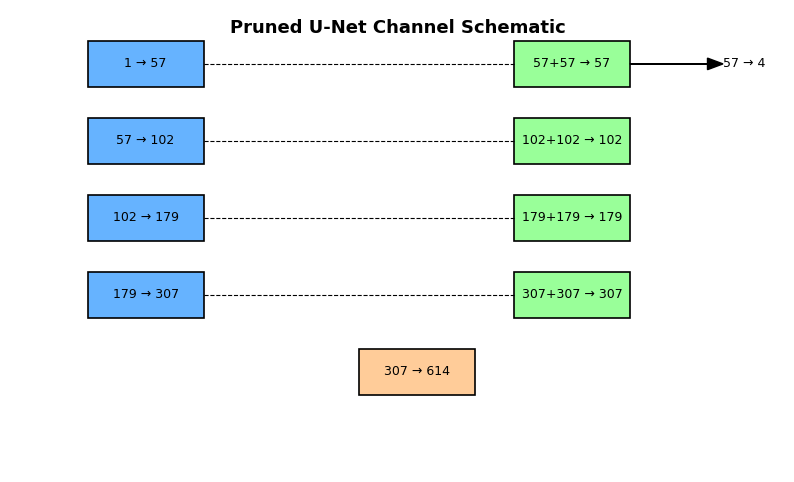

🚀 Running evaluation on test set...


Evaluating: 100%|██████████| 3000/3000 [00:30<00:00, 98.61it/s] 


✅ Evaluation complete!
📊 Mean Dice: 0.0949
📊 Mean IoU:  0.0912
───────────────────────────────
Background    Dice=0.0000  IoU=0.0000
RV            Dice=0.0318  IoU=0.0171
Myocardium    Dice=0.1100  IoU=0.1100
LV            Dice=0.2377  IoU=0.2377
───────────────────────────────
💾 Metrics saved to results/UNet_ACDC/exp1/pruned/evaluation/eval_metrics.json


In [8]:
evaluate()